# Master's Thesis Experiments Report

In [118]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageChops

from scripts.utils import load_latency_data, load_frame_size_data

In [119]:
# constants
FIG_DIR = './figures/{}'
OUT_DIR = './data/out'
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

## 1.   Pipeline Latency
The data was replayed at 8 Mbps.
For each frame f, we measure the timedelta between the last emitted LiDAR data packet and
the last incoming Palicus data packet containing data associated with f.
We exclude the first and the last frame to ensure that we only consider the latency of full frames.

In [120]:
fig_dir = FIG_DIR.format('latency')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [121]:
# Load the data
df_conversion = load_latency_data(pipeline='conversion')
df_roi = load_latency_data(pipeline='roi')
df_dm1 = load_latency_data(pipeline='dm1')
df_dm2 = load_latency_data(pipeline='dm2')
df_bev = load_latency_data(pipeline='bev')

In [122]:
# tabular representation
l = 'latency [ms]'

results = [['min', df_conversion.min()[l], df_roi.min()[l], df_dm1.min()[l], df_dm2.min()[l], df_bev.min()[l]],
           ['mean', df_conversion.mean()[l], df_roi.mean()[l], df_dm1.mean()[l], df_dm2.mean()[l], df_bev.mean()[l]],
           ['median', df_conversion.median()[l], df_roi.median()[l], df_dm1.median()[l], df_dm2.median()[l],
            df_bev.median()[l]],
           ['max', df_conversion.max()[l], df_roi.max()[l], df_dm1.max()[l], df_dm2.max()[l], df_bev.max()[l]]
           ]

df_latency_results = pd.DataFrame(results, columns=['', 'CONV', 'RoI', 'DM (1)', 'DM (2)', 'BEV'])
print(df_latency_results)


               CONV       RoI    DM (1)    DM (2)        BEV
0     min  0.190000  0.189333  0.187667  0.185000   0.294000
1    mean  0.390525  0.391811  0.393795  0.393548  46.143263
2  median  0.299333  0.296333  0.298667  0.298667  47.705000
3     max  1.655333  1.603333  1.584000  1.574000  47.807667


In [123]:
# convert ms -> us
df_conversion['latency [us]'] = df_conversion['latency [ms]'] * 1000
df_roi['latency [us]'] = df_roi['latency [ms]'] * 1000
df_dm1['latency [us]'] = df_dm1['latency [ms]'] * 1000
df_dm2['latency [us]'] = df_dm2['latency [ms]'] * 1000

### Latency Impact of PEs

In [124]:
CONV_OUTLIER_FRAMES = df_conversion.loc[df_conversion['latency [ms]'] > 1.0, 'frame_nr'].to_numpy()
ROI_OUTLIER_FRAMES = df_roi.loc[df_roi['latency [ms]'] > 1.0, 'frame_nr'].to_numpy()
BEV_OUTLIER_FRAMES = df_bev.loc[df_bev['latency [ms]'] < 1.0, 'frame_nr'].to_numpy()

ftr = 'diff'

#### Filtering

In [125]:
# FPE - impact in [us]
df_1 = df_conversion.rename(columns={'latency [us]': 'CONV'})
df_1 = df_1.loc[:, ['frame_nr', 'CONV']]
for f in CONV_OUTLIER_FRAMES:
    df_1 = df_1.loc[df_1['frame_nr'] != f]

df_2 = df_roi.rename(columns={'latency [us]': 'RoI'})
df_2 = df_2.loc[:, ['frame_nr', 'RoI']]
for f in ROI_OUTLIER_FRAMES:
    df_2 = df_2.loc[df_2['frame_nr'] != f]

# FPE - impact in [us]
df_compare_fpe = pd.merge(df_1, df_2, how='inner', on='frame_nr')
df_compare_fpe[ftr] = df_compare_fpe['RoI'] - df_compare_fpe['CONV']

res_table = [['FPE [us]', df_compare_fpe.min()[ftr],
              df_compare_fpe.mean()[ftr], df_compare_fpe.median()[ftr],
              df_compare_fpe.max()[ftr]]]



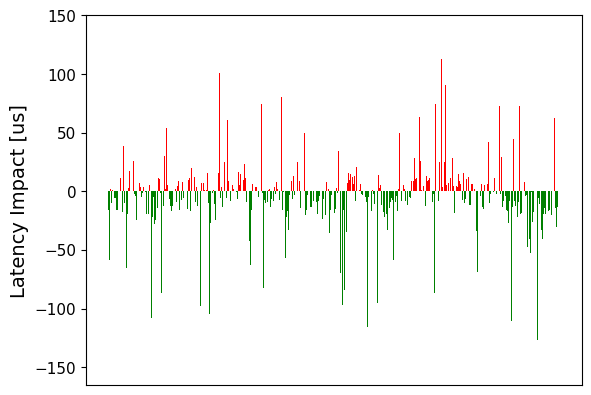

In [148]:
# BAR CHART
df_compare_fpe.sort_values(by='frame_nr', ascending=True, inplace=True)
frames = df_compare_fpe.loc[:, 'frame_nr'].to_numpy()
data = df_compare_fpe.loc[:, ftr].to_numpy()

fig, ax = plt.subplots()
ax.bar(x=frames, height=data, color=['green' if val < 0 else 'red' for val in data])
ax.set_ylabel('Latency Impact [us]', fontsize=14)
ax.set(xticks=[], yticks=[i*50-150 for i in range(7)])
ax.tick_params(axis='both', which='major', labelsize=11)
plt.show()
fig.savefig('./figures/latency/fpe_impact_bar.png')

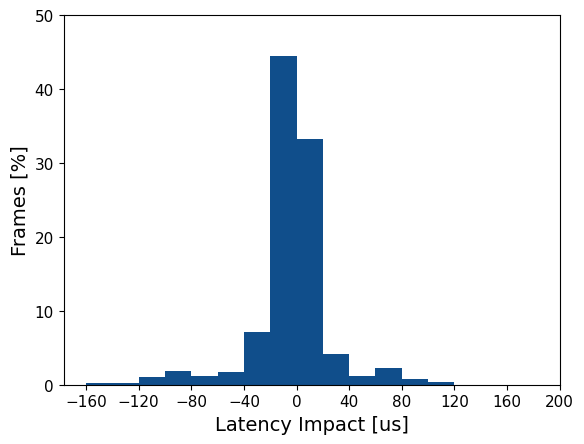

In [127]:
# HISTOGRAM
FPE_BINS = [i*20-160 for i in range(18)]
fpe_counts, _ = np.histogram(df_compare_fpe[ftr].to_numpy(), bins=FPE_BINS)
fpe_counts = fpe_counts / np.sum(fpe_counts) * 100

fig, ax = plt.subplots()
ax.hist(FPE_BINS[:-1], FPE_BINS, weights=fpe_counts, label='FPE', color='#104E8B')
ax.set_xlabel('Latency Impact [us]', fontsize=14)
ax.set_ylabel('Frames [%]', fontsize=14)
ax.set(xticks=[i*40 -160 for i in range(10)], yticks=[i*10 for i in range(6)])
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()
fig.savefig(os.path.join(fig_dir, 'fpe_impact_hist.png'))

#### Arithmetic

In [128]:
# ArPE - impact in [us]
df_2 = df_roi.rename(columns={'latency [us]': 'RoI'})
df_2 = df_2.loc[:, ['frame_nr', 'RoI']]

df_3 = df_dm1.rename(columns={'latency [us]': 'DM(1)'})
df_3 = df_3.loc[:, ['frame_nr', 'DM(1)']]

df_compare_arpe = pd.merge(df_2, df_3, how='inner', on='frame_nr')
df_compare_arpe[ftr] = df_compare_arpe['DM(1)'] - df_compare_arpe['RoI']

res_table.append(['ArPE [us]', df_compare_arpe.min()[ftr],
              df_compare_arpe.mean()[ftr], df_compare_arpe.median()[ftr],
              df_compare_arpe.max()[ftr]])

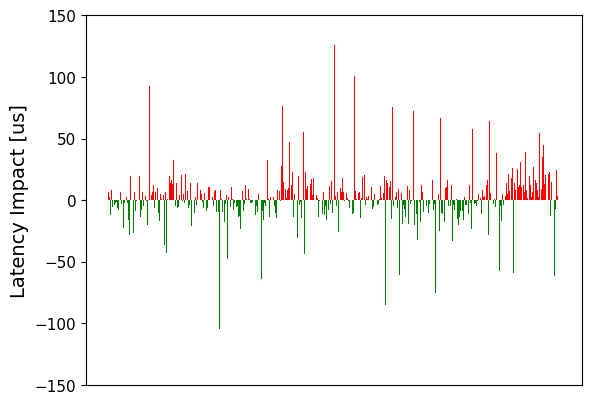

In [149]:
# BAR CHART
df_compare_arpe.sort_values(by='frame_nr', ascending=True, inplace=True)
frames = df_compare_arpe.loc[:, 'frame_nr'].to_numpy()
data = df_compare_arpe.loc[:, ftr].to_numpy()

fig, ax = plt.subplots()
ax.bar(x=frames, height=data, color=['green' if val < 0 else 'red' for val in data])
ax.set_ylabel('Latency Impact [us]', fontsize=14)
ax.set(xticks=[], yticks=[i*50-150 for i in range(7)])
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()
fig.savefig('./figures/latency/arpe_impact_bar.png')

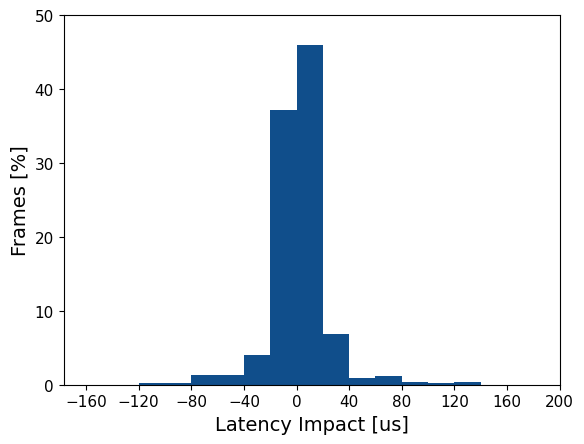

In [130]:
# HISTOGRAM
ARPE_BINS = [i*20-160 for i in range(18)]
arpe_counts, _ = np.histogram(df_compare_arpe[ftr].to_numpy(), bins=ARPE_BINS)
arpe_counts = arpe_counts / np.sum(arpe_counts) * 100

fig, ax = plt.subplots()
ax.hist(ARPE_BINS[:-1], ARPE_BINS, weights=arpe_counts, label='ArPE', color='#104E8B')
ax.set_xlabel('Latency Impact [us]', fontsize=14)
ax.set_ylabel('Frames [%]', fontsize=14)
ax.set(xticks=[i*40 -160 for i in range(10)], yticks=[i*10 for i in range(6)])
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()
fig.savefig(os.path.join(fig_dir, 'arpe_impact_hist.png'))

#### Aggregation

In [131]:
# AggPE - impact in [ms]
df_4 = df_dm2.rename(columns={'latency [ms]': 'DM(2)'})
df_4 = df_4.loc[:, ['frame_nr', 'DM(2)']]
for f in ROI_OUTLIER_FRAMES:
    df_4 = df_4.loc[df_4['frame_nr'] != f]

df_5 = df_bev.rename(columns={'latency [ms]': 'BEV'})
df_5 = df_5.loc[:, ['frame_nr', 'BEV']]
for f in BEV_OUTLIER_FRAMES:
    df_5 = df_5.loc[df_5['frame_nr'] != f]

df_compare_aggpe = pd.merge(df_4, df_5, how='inner', on='frame_nr')
df_compare_aggpe[ftr] = df_compare_aggpe['BEV'] - df_compare_aggpe['DM(2)']

res_table.append(['AggPE [ms]', df_compare_aggpe.min()[ftr],
                  df_compare_aggpe.mean()[ftr], df_compare_aggpe.median()[ftr],
                  df_compare_aggpe.max()[ftr]])

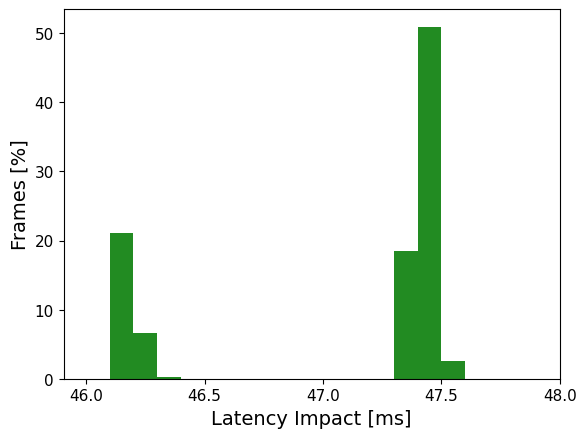

In [132]:
# HISTOGRAM
AGG_BINS = [46 + i / 10  for i in range(20)]
aggpe_counts, _ = np.histogram(df_compare_aggpe[ftr].to_numpy(), bins=AGG_BINS)
aggpe_counts = aggpe_counts / np.sum(aggpe_counts) * 100

fig, ax = plt.subplots()
ax.hist(AGG_BINS[:-1], AGG_BINS, weights=aggpe_counts, label='AggPE', color='#228b22')
ax.set_xlabel('Latency Impact [ms]', fontsize=14)
ax.set_ylabel('Frames [%]', fontsize=14)
ax.set(xticks=[46, 46.5, 47, 47.5, 48], yticks=[i*10 for i in range(6)])
ax.tick_params(axis='both', which='major', labelsize=11)

plt.show()
fig.savefig(os.path.join(fig_dir, 'aggpe_impact_hist.png'))

In [133]:
# raw numbers
df_res = pd.DataFrame(res_table, columns=['', 'min', 'mean', 'median', 'max'])
print(df_res)

                      min       mean     median         max
0    FPE [us] -152.000000  -4.488565  -3.333333  113.000000
1   ArPE [us] -104.333333   1.984127   1.333333  133.666667
2  AggPE [ms]   46.126000  47.073534  47.402667   47.522667


#### Impact of FPE on Frame Size

In [134]:
# Conversion
conv_elements = load_frame_size_data(pipeline='conversion')
# RoI
roi_elements = load_frame_size_data(pipeline='roi')


df_compare_elements = pd.concat([conv_elements.loc[:, 'n_elements'].rename('CONV'),
                                roi_elements.loc[:, 'n_elements'].rename('RoI')], axis=1)
df_compare_elements['ratio'] = df_compare_elements['RoI'] / df_compare_elements['CONV'] * 100

print('min\t\t', df_compare_elements.min()['ratio'])
print('mean\t', df_compare_elements.mean()['ratio'])
print('median\t', df_compare_elements.median()['ratio'])
print('max\t\t', df_compare_elements.max()['ratio'])

min		 95.36396346526432
mean	 95.55547517144353
median	 95.55843706777317
max		 95.65698478561549


In [135]:
# Number of outlier frames
conv_num_outliers = len(df_conversion.loc[df_conversion['latency [ms]'] > 1])
roi_num_outliers = len(df_roi.loc[df_roi['latency [ms]'] > 1])
dm1_num_outliers = len(df_dm1.loc[df_dm1['latency [ms]'] > 1])
dm2_num_outliers = len(df_dm2.loc[df_dm2['latency [ms]'] > 1])
print(conv_num_outliers, roi_num_outliers, dm1_num_outliers, dm2_num_outliers)

39 42 42 42


## 2. Precision

In [136]:
# Pipeline 1: RoI


In [137]:
# --- visualize --- #
# ToDo



In [138]:
# Pipeline 2: BEV - max(z)


In [139]:
# --- visualize --- #
gt_img = Image.open('./figures/precision/bev/000080/ground_truth.png')
pal_img = Image.open('./figures/precision/bev/000080/palicus.png')
diff = ImageChops.difference(gt_img, pal_img)
diff.save('./figures/precision/bev/000080/delta.png')

display(gt_img)
display(pal_img)
display(diff)

In [140]:
# Pipeline 3: BEV - mean(i)

In [141]:
# --- visualize --- #
gt_img = Image.open('./figures/precision/bev_mean/000522/ground_truth.png')
pal_img = Image.open('./figures/precision/bev_mean/000522/palicus.png')
diff = ImageChops.difference(gt_img, pal_img)
diff.save('./figures/precision/bev_mean/000522/delta.png')

display(gt_img)
display(pal_img)
display(diff)

## 3. Throughput

In [142]:
# load the ground truth
all_gt = pd.read_csv('./data/conversion/throughput/frame_size_gt.csv').sum()['n_elements']
filtered_gt = pd.read_csv('./data/roi/throughput/frame_size_gt.csv').sum()['n_elements']
bev_gt = pd.read_csv('./data/bev/throughput/frame_size_gt.csv').sum()['n_elements']

print(all_gt, filtered_gt, bev_gt)

30381904 29031584 133378


In [143]:
# -- overview --
total_elem = []
cols = ['Pipeline', 'GT', '8Mbps', '16Mbps', '32Mbps', '64Mbps', '128Mbps']
for p in ['conversion', 'roi', 'dm1', 'dm2', 'bev']:
    gt = all_gt if p == 'conversion' else bev_gt if p == 'bev' else filtered_gt
    log = [p, gt]
    for t in [8, 16, 32, 64, 128]:
        df = load_frame_size_data(pipeline=p, throughput=t)
        total = df.sum()['n_elements']
        log.append(total)
    total_elem.append(log)

df_res = pd.DataFrame(np.array(total_elem), columns=cols)
df_res.to_csv(os.path.join(OUT_DIR, 'throughput_overview.csv'), index=False)
print(df_res)

     Pipeline        GT     8Mbps    16Mbps    32Mbps    64Mbps   128Mbps
0  conversion  30381904  30381904  30381904  30381904  30381904  30381904
1         roi  29031584  29031573  29031573  29031573  29031573  29030687
2         dm1  29031584  29031573  29031573  29031573  29031573  29031189
3         dm2  29031584  29031573  29031573  29031573  29031573  29031573
4         bev    133378    139197    139197    139197    139197    139196


### Frames Deviating in Size

In [144]:
# RoI: 8 Mbps - 128 Mbps
df_8 = load_frame_size_data(pipeline='roi', throughput=8).rename(columns={'n_elements': '8 Mbps'})
df_128 = load_frame_size_data(pipeline='roi', throughput=128).rename(columns={'n_elements': '128 Mbps'})

df_compare = pd.merge(df_8, df_128, how='inner', on='frame_nr')
df_compare['diff'] = df_compare['8 Mbps'] - df_compare['128 Mbps']
df_compare = df_compare.loc[df_compare['diff'] != 0]
print(df_compare)

     frame_nr  8 Mbps  128 Mbps  diff
28         29   55254     54870   384
41         42   55285     55167   118
356       357   55243     54859   384


In [145]:
# DM (1): 8 Mbps - 128 Mbps
df_8 = load_frame_size_data(pipeline='dm1', throughput=8).rename(columns={'n_elements': '8 Mbps'})
df_128 = load_frame_size_data(pipeline='dm1', throughput=128).rename(columns={'n_elements': '128 Mbps'})

df_compare = pd.merge(df_8, df_128, how='inner', on='frame_nr')
df_compare['diff'] = df_compare['8 Mbps'] - df_compare['128 Mbps']
df_compare = df_compare.loc[df_compare['diff'] != 0]
print(df_compare)

     frame_nr  8 Mbps  128 Mbps  diff
108       109   55281     54897   384


In [146]:
# BEV: 8 Mbps - 128 Mbps
df_8 = load_frame_size_data(pipeline='bev', throughput=8).rename(columns={'n_elements': '8 Mbps'})
df_128 = load_frame_size_data(pipeline='bev', throughput=128).rename(columns={'n_elements': '128 Mbps'})

df_compare = pd.merge(df_8, df_128, how='inner', on='frame_nr')
df_compare['diff'] = df_compare['8 Mbps'] - df_compare['128 Mbps']
df_compare = df_compare.loc[df_compare['diff'] != 0]
print(df_compare)

     frame_nr  8 Mbps  128 Mbps  diff
420       421     263       262     1


### BEV Processing Time

In [147]:
df_lat_8 = pd.read_csv('./data/bev/throughput/latency/latency_8.csv').loc[1:525]
df_lat_16 = pd.read_csv('./data/bev/throughput/latency/latency_16.csv').loc[1:525]
df_lat_32 = pd.read_csv('./data/bev/throughput/latency/latency_32.csv').loc[1:525]
df_lat_64 = pd.read_csv('./data/bev/throughput/latency/latency_64.csv').loc[1:525]
df_lat_128 = pd.read_csv('./data/bev/throughput/latency/latency_128.csv').loc[1:525]

print('\t\t'.join(cols[2:]))
print(round(df_lat_8.mean()['latency [ms]'], 3), '\t\t', round(df_lat_16.mean()['latency [ms]'], 3), '\t', round(df_lat_32.mean()['latency [ms]'], 3), '\t', round(df_lat_64.mean()['latency [ms]'], 3), '\t\t', round(df_lat_128.mean()['latency [ms]'], 3))



8Mbps		16Mbps		32Mbps		64Mbps		128Mbps
46.145 		 23.213 	 11.614 	 6.004 		 3.151
